In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
from tqdm import tqdm
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from datetime import datetime
from torchvision import models
#from transformers import CLIPProcessor, CLIPModel
import os
import csv
from peft import LoraConfig, get_peft_model
import json

import pandas as pd
import os
import random
import numpy as np
import torch
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import json

import transformers
from transformers import CLIPProcessor, CLIPModel
from multilingual_clip import pt_multilingual_clip # Note: add device parameter to forward manually
import open_clip


from torch.utils.data import DataLoader, Dataset
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# loading variables from .env file
load_dotenv("../../private_data/.env") 

# PARENT gets us to the root of the project
PARENT = "./../../"

FOLDER_TABLE = PARENT + os.getenv("FOLDER_TABLE")
FILE_FABRITIUS_DATA = PARENT + os.getenv("FILE_FABRITIUS_DATA")
FILE_FABRITIUS_DATA_FILTERED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED")
FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED")
FOLDER_FIGURES = PARENT + os.getenv("FOLDER_FIGURES")
IMAGES_FOLDER = PARENT + os.getenv("IMAGES_FOLDER")

FILE_SUBJECTMATTERS_PARSED = PARENT + os.getenv("FILE_SUBJECTMATTERS_PARSED")

DB_INPUT_ARTPIECES = PARENT + os.getenv("DB_INPUT_ARTPIECES")
DB_INPUT_ARTISTS = PARENT + os.getenv("DB_INPUT_ARTISTS")
FILE_SUBJECTMATTERS_PARSED = PARENT + os.getenv("FILE_SUBJECTMATTERS_PARSED")

MODELS_FOLDER = PARENT + os.getenv("MODELS_FOLDER")

In [4]:
model_name = "openai/clip-vit-large-patch14"
processor = CLIPProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name).to(device)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
# Load the weights of the model
weights_path = os.path.join(MODELS_FOLDER, "art-base.pt")
# Load the weights of the model
model.load_state_dict(torch.load(weights_path, map_location=device))

C:\Users\victo\AppData\Local\Temp\ipykernel_9428\1118417068.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location=d

<All keys matched successfully>

In [5]:
model_name_db = "art-base"
path_embeddings = PARENT + os.getenv(f"{model_name_db}_path_embeddings")
path_index_to_recordID = PARENT + os.getenv(f"{model_name_db}_path_index_to_recordID")
Embeddings = np.load(path_embeddings)
Embeddings.shape

(5301, 768)

In [6]:
# Get the artworks data
ARTWORKS = pd.read_csv(DB_INPUT_ARTPIECES)
# Sort ARTWORKS by the recordID 
ARTWORKS = ARTWORKS.sort_values(by=['recordID'])
ARTWORKS.head(1)

,recordID,workID,creatorID,language,title,objectWorkType,termClassification,materials,signatureFullDescription,creationFullDescription,...,physicalAppearanceDescription,imageType,imageColor,imageLowResFilename,imageHighResFilename,imageCopyright,formalDescriptionTermStylesPeriods,height,width,ratio
0,64,8181,Auth:509:309,fre,La Crucifixion,détrempe,peinture (Dept. Art Ancien),toile|tempera,NaN,1460.0,...,Tempera sur toile,digitale JPG,photo couleurs,/art-foto/old/internet/Bouts-8181dig-L.jpg,/art-foto/old/intranet/Bouts-8181dig-H.jpg,NaN,Primitifs flamands,181.5,153.5,0.84573


In [7]:
class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        text = self.texts[idx]
        return text

def customTextBatchBuilder(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    return inputs

def compute_keywords_embeddings(dataloader, model, device):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for sample in tqdm(dataloader):
            input_ids = sample['input_ids'].to(device)
            attention_mask = sample['attention_mask'].to(device)

            # Compute the embeddings
            text_features = model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            text_features = text_features.flatten(1)

            embeddings.append(text_features)

    embeddings = torch.cat(embeddings, dim=0)
    embeddings = embeddings.cpu().numpy()
    return embeddings

In [8]:
# Get the artworks data
ARTISTS = pd.read_csv(DB_INPUT_ARTISTS)
ARTISTS.head(1)

,creatorID,creatorLastName,creatorFirstName,creatorBirthAndDeathDescription,creatorNationality,creatorDeathDate,creatorBirthDate
0,Auth:509:309,Bouts,Dirk,Haarlem (Pays-Bas) vers 1410 ? - Louvain 1475,NaN,1475.0,1410.0


In [9]:
# Methods to get an image from a recordID
def fixPath(path):
    return path.replace(".././", "../")

recordID_to_imageLowResFilename = {}
for index, row in ARTWORKS.iterrows():
    recordID = row["recordID"]
    path = row["imageLowResFilename"]

    # Fix the imageLowResFilename
    path = fixPath(IMAGES_FOLDER + path[1:])

    path = path.replace("internet", "Internet")
    path = path.replace("Mod", "mod")
    path = path.replace("MOD", "mod")
    path = path.replace("Old", "old")
    path = path.replace("Stefaan", "stefaan")
    path = path.replace("Art-Foto", "art-foto")
    path = path.replace("\\", "/")

    recordID_to_imageLowResFilename[recordID] = path

# Test it
for recordID, path in recordID_to_imageLowResFilename.items():
    if not os.path.exists(path):
        print(f"Path does not exist: {path}")

In [10]:
index_to_recordID = json.load(open(path_index_to_recordID, "r"))
index_to_recordID = {int(k): v for k, v in index_to_recordID.items()}

In [11]:
recordID_to_index = {v: k for k, v in index_to_recordID.items()}

In [12]:
subjectmatter_json = json.loads(open(FILE_SUBJECTMATTERS_PARSED, "r", encoding="utf-8").read())

# dict_keys()
def get_structured_flattened(recordID):

    index = -1
    for i, entry in enumerate(subjectmatter_json):
        if entry["recordID"] == recordID:
            index = i
            break

    terms_tot = set()
    for key in ['subjectMatterSubjectTerms', 'subjectMatterIconographicTerms', 'subjectMatterConceptualTerms']:
        terms = subjectmatter_json[index]["structured"][key]["flattened"]
        # Remove proper nouns (term with at least one uppercase letter)
        terms_com = set()
        for term in terms:
            if not any(c.isupper() for c in term):
                terms_com.add(term.lower())
                 
        terms_tot.update(terms_com)

    if int(recordID) == 10818:
        print(f"RecordID: {recordID}, Terms: {terms_tot}")

    return terms_tot

In [13]:
terms_per_recordID = {}
for recordID in tqdm(ARTWORKS["recordID"]):
    terms = get_structured_flattened(recordID)
    terms_per_recordID[recordID] = terms

unique_terms = set()
for terms in terms_per_recordID.values():
    unique_terms.update(terms)

# Remove terms that appear less than Z
Z = 2
term_counts = {}
for terms in terms_per_recordID.values():
    for term in terms:
        if term in term_counts:
            term_counts[term] += 1
        else:
            term_counts[term] = 1

unique_terms = {term for term, count in term_counts.items() if count >= Z}
for recordID, terms in terms_per_recordID.items():
    terms_per_recordID[recordID] = {term for term in terms if term in unique_terms}

unique_terms = sorted(list(unique_terms))
term_to_index = {term: i for i, term in enumerate(unique_terms)}

print(f"Number of unique terms: {len(unique_terms)} appearing at least {Z} times")

 83%|████████▎ | 4418/5301 [00:00<00:00, 5327.07it/s] 

RecordID: 10818, Terms: {'vêtement', 'femme', 'à califourchon', 'fleuve', 'groupe de figures', 'homme', 'traversée', 'eau', 'falaise', 'chapeau', 'cruche', 'bâton', 'scène', 'enfant'}


100%|██████████| 5301/5301 [00:01<00:00, 5109.41it/s]

Number of unique terms: 1309 appearing at least 2 times


Title: Paysans passant un gué


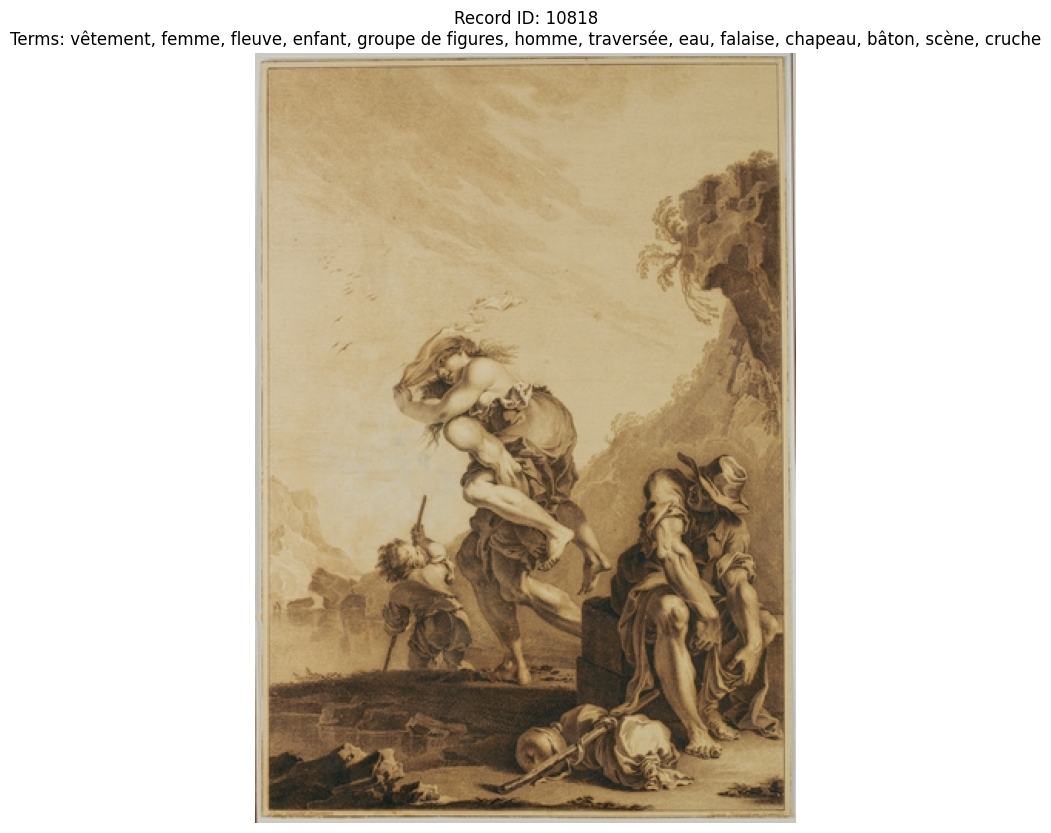

In [14]:
def plot_image_and_terms(recordID):
    # Get the image path
    image_path = recordID_to_imageLowResFilename[recordID]
    
    # Load the image
    image = Image.open(image_path)
    
    # Get the terms
    terms = terms_per_recordID[recordID]
    
    # Plot the image and terms
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(f"Record ID: {recordID}\nTerms: {', '.join(terms)}")
    plt.show()

# Example usage
recordID = 10818
title = ARTWORKS[ARTWORKS["recordID"] == recordID]["title"].values[0]
print(f"Title: {title}")
plot_image_and_terms(recordID)

In [15]:
all_recordIDs = set(ARTWORKS["recordID"].values)
wterms_recordIDs = set()
woterms_recordIDs = set()
for recordID, terms in terms_per_recordID.items():
    if len(terms) > 0:
        wterms_recordIDs.add(recordID)
    else:
        woterms_recordIDs.add(recordID)

wterms_recordIDs = sorted(list(wterms_recordIDs))
woterms_recordIDs = sorted(list(woterms_recordIDs))

print(f"Number of artworks with terms: {len(wterms_recordIDs)}")
print(f"Number of artworks without terms: {len(woterms_recordIDs)}")

Number of artworks with terms: 3641
Number of artworks without terms: 1660


In [16]:
nb_splits = 5

test_size = 500
train_size = len(wterms_recordIDs) - test_size

random.seed(0)

splits = []
for i in range(nb_splits):

    indexes = list(range(len(wterms_recordIDs)))
    random.shuffle(indexes)

    train_indexes = indexes[:train_size]
    test_indexes = indexes[train_size:]

    train_recordIDs = [wterms_recordIDs[i] for i in train_indexes]
    test_recordIDs = [wterms_recordIDs[i] for i in test_indexes]

    splits.append((train_recordIDs, test_recordIDs))


for i, (train_recordIDs, test_recordIDs) in enumerate(splits):
    print(f"Split {i+1}: {len(train_recordIDs)} train, {len(test_recordIDs)} test, {len(set(train_recordIDs).union(set(test_recordIDs)))} total")
    if (i+1)==nb_splits:
        print("Some examples:")
        for j in range(3):
            train_recordID = train_recordIDs[j]
            test_recordID = test_recordIDs[j]
            print(f"    > Train: {train_recordID}, Test: {test_recordID}")

Split 1: 3141 train, 500 test, 3641 total
Split 2: 3141 train, 500 test, 3641 total
Split 3: 3141 train, 500 test, 3641 total
Split 4: 3141 train, 500 test, 3641 total
Split 5: 3141 train, 500 test, 3641 total
Some examples:
    > Train: 2728, Test: 687
    > Train: 8573, Test: 7378
    > Train: 6250, Test: 292


In [17]:
terms_dataset = TextDataset(unique_terms)
terms_dataloader = DataLoader(terms_dataset, batch_size=32, shuffle=False, collate_fn=customTextBatchBuilder)

term_embeddings = compute_keywords_embeddings(terms_dataloader, model, device)
term_to_embeddings = {term: embedding for term, embedding in zip(unique_terms, term_embeddings)}
print(f"Number of terms embeddings: {len(term_to_embeddings)}")

100%|██████████| 41/41 [00:00<00:00, 73.61it/s]

Number of terms embeddings: 1309


In [18]:
def visualize(
    predictor,

    e_i,
    a_i,
    indexToAvoid,

    terms_per_identifier,
    known,
    banned,
    min_sim,
    epsilon,
    regionality,
    alpha,
    useTermsSimilarity,
    N
):
    # Plot the image
    image_path = recordID_to_imageLowResFilename[a_i]
    image = Image.open(image_path)
    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap='gray')
    plt.axis('off')


    predicted_terms, scores = predictor(
        a_i,
        e_i,
        terms_per_identifier,
        min_sim=min_sim, 
        epsilon=epsilon, 
        regionality=regionality, 
        alpha=alpha, 
        useTermsSimilarity=useTermsSimilarity, 
        N=N, 
        known=known, 
        banned=banned
    )
    
    print(f"Predicted terms for recordID {a_i} (embedding index {indexToAvoid}):")
    for term, score in zip(predicted_terms, scores):
        print(f"    > {term} : {score:.4f}")

    
    plt.title(f"Record ID: {a_i}\nEmbedding Index: {indexToAvoid}")
    plt.show()

In [19]:
# Let E be the embeddings of the training set
E = []
for recordID in wterms_recordIDs:
    index = recordID_to_index[recordID]
    embedding = Embeddings[index]
    E.append(embedding)
E = np.array(E)

# Let T be the embeddings of the terms
T = np.array([term_to_embeddings[term] for term in unique_terms])

True terms for recordID 7598:
{'chasseur', 'vêtement', 'groupe de figures', 'animal', 'homme', 'éléphant', 'javelot', 'bouclier', 'arme', 'nuage', 'couvre-chef', 'épée', 'fusil', "transport à dos d'animal", 'local', 'effet de lumière', 'effet de soleil', 'plaine', 'ciel'}
Predicted terms for recordID 7598 (embedding index 3661):
    > homme : 1.0000
    > figure : 0.7721
    > femme : 0.7354
    > groupe de figures : 0.5238


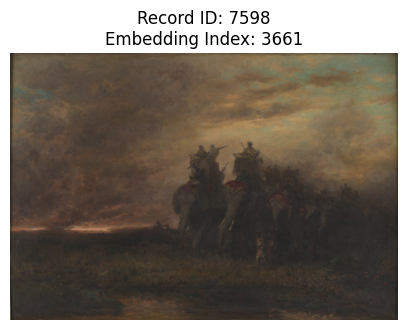

In [20]:
def simple_predict(
    train_identifiers,
    E,
    T
):
    appearance_per_term = np.zeros((len(unique_terms)), dtype=np.float32)
    for recordID in train_identifiers:
        terms = terms_per_recordID[recordID]
        for term in terms:
            termIndexs = term_to_index[term]
            appearance_per_term[termIndexs] += 1

    frequency_per_term = appearance_per_term / len(train_identifiers)

    # Sort by frequency from high to low
    sorted_term_indices = np.argsort(frequency_per_term)[::-1]
    sorted_terms = [unique_terms[i] for i in sorted_term_indices]
    sorted_frequencies = frequency_per_term[sorted_term_indices]

    # Normalize the scores to [0, 1]
    sorted_frequencies = (sorted_frequencies - sorted_frequencies.min()) / (sorted_frequencies.max() - sorted_frequencies.min())

    def predict_func(
        # Let a_i be the identifier of the artwork we want to predict terms for
        a_i,
        # Let e_i be the embedding of the a_i
        e_i,
        # The terms per identifier
        terms_per_identifier,

        # Hyperparameters
            # The minimum similarity to consider a neighbour
            min_sim=0.0,       
            # Small value to avoid division by zero
            epsilon=1e-10,      
            # Regionality impacts how much the close neighbours influence the score compared to the distant ones
            regionality=20.0,
            # The alpha parameter to control the influence of known/banned multiplier (between 0 and 1)
            alpha=0.1,
            # Whether to use the terms similarity in the score computation
            useTermsSimilarity=True,
            # Let N be either the number of terms to return or the threshold for the scores
            N=0.5,
            # Let known be the list of terms already known for the a_i
            known=[], 
            # Let banned be the list of terms to avoid in the prediction
            banned=[], 
    ):
        try:
            N = float(N)
        except ValueError:
            raise ValueError("N must be a number")
        
        # The mode of the predictor, either return the top N terms or all terms above a threshold
        if N > 0 and N < 1:
            mode = "threshold"
        elif N >= 1:
            N = int(N)
            N = min(N, len(unique_terms))
            mode = "up_to_N"
        else:
            raise ValueError("N must be a positive number or a fraction between 0 and 1")

        if mode == "up_to_N":
            kept_terms = []
            kept_frequencies = []
            for termIndex, term in enumerate(sorted_terms):
                if term not in known and term not in banned:
                    kept_terms.append(term)
                    kept_frequencies.append(sorted_frequencies[termIndex])
                if len(kept_terms) >= N:
                    break

            return kept_terms, kept_frequencies
        elif mode == "threshold":
            kept_terms = []
            kept_frequencies = []
            for termIndex, term in enumerate(sorted_terms):
                if term not in known and term not in banned:
                    if sorted_frequencies[termIndex] >= N:
                        kept_terms.append(term)
                        kept_frequencies.append(sorted_frequencies[termIndex])

            return kept_terms, kept_frequencies

    return predict_func

# Test it !
predictor = simple_predict(
    wterms_recordIDs, 
    E, 
    T
)

recordID = random.choice(wterms_recordIDs)
recordID = 7598
true_terms = terms_per_recordID[recordID]
print(f"True terms for recordID {recordID}:\n{true_terms}")
index = recordID_to_index[recordID]
e_i = Embeddings[index]
known = []
banned = []

visualize(
    predictor,
    e_i,
    recordID,
    index,
    terms_per_recordID,
    known=known,
    banned=banned,
    min_sim=0.0, 
    epsilon=1e-10, 
    regionality=20.0, 
    alpha=0.1, 
    useTermsSimilarity=True, 
    N=0.5
)

True terms for recordID 7598:
{'chasseur', 'vêtement', 'groupe de figures', 'animal', 'homme', 'éléphant', 'javelot', 'bouclier', 'arme', 'nuage', 'couvre-chef', 'épée', 'fusil', "transport à dos d'animal", 'local', 'effet de lumière', 'effet de soleil', 'plaine', 'ciel'}
Predicted terms for recordID 7598 (embedding index 3661):
    > paysage : 1.0000
    > groupe de figures : 0.9205
    > scène : 0.9101
    > chien : 0.7191
    > chameau : 0.6441
    > caravane : 0.6345
    > âne : 0.5812
    > sable : 0.5649
    > en pied : 0.5585
    > fond de paysage : 0.5585
    > femme : 0.5503
    > rocher : 0.5363
    > désert : 0.5308
    > eau : 0.5308
    > enfant : 0.5220
    > tempête : 0.5110
    > forêt : 0.5029


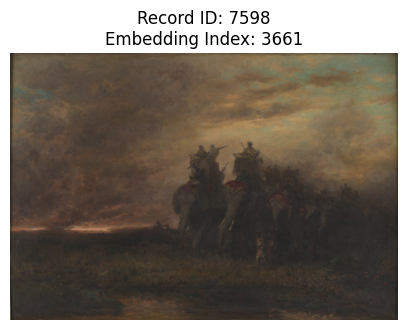

In [21]:
def predict_with_CLIP_neighbours(
    train_identifiers,
    E,
    T
    ):
    # Caching mechanism to avoid recomputing the sorted terms 
    # for the same artwork, known and banned terms
    sorted_terms_cache = {}
    def getHash(e_i, a_i, min_sim, epsilon, regionality, alpha, useTermsSimilarity, known, banned):
        hash_parts = tuple([str(e_i.tolist()), str(a_i), str(min_sim), str(epsilon), str(regionality), str(alpha), str(useTermsSimilarity), tuple(known), tuple(banned)])
        return hash(hash_parts)

    def predict_func(
        # Let a_i be the identifier of the artwork we want to predict terms for
        a_i,
        # Let e_i be the embedding of the a_i
        e_i,
        # The terms per identifier
        terms_per_identifier,

        # Hyperparameters
            # The minimum similarity to consider a neighbour
            min_sim=0.0,       
            # Small value to avoid division by zero
            epsilon=1e-10,      
            # Regionality impacts how much the close neighbours influence the score compared to the distant ones
            regionality=20.0,
            # The alpha parameter to control the influence of known/banned multiplier (between 0 and 1)
            alpha=0.1,
            # Whether to use the terms similarity in the score computation
            useTermsSimilarity=True,
            # Let N be either the number of terms to return or the threshold for the scores
            N=0.5,
            # Let known be the list of terms already known for the a_i
            known=[], 
            # Let banned be the list of terms to avoid in the prediction
            banned=[], 
        ):     
        try:
            N = float(N)
        except ValueError:
            raise ValueError("N must be a number")
        
        # The mode of the predictor, either return the top N terms or all terms above a threshold
        if N > 0 and N < 1:
            mode = "threshold"
        elif N >= 1:
            N = int(N)
            N = min(N, len(unique_terms))
            mode = "up_to_N"
        else:
            raise ValueError("N must be a positive number or a fraction between 0 and 1")
        
        assert alpha >= 0 and alpha <= 1, "Alpha must be between 0 and 1"

        # Necessary if we want to allow the user to provide 
        # his own known and banned terms that are not in the unique_terms
        # We could also extend the unique_terms and compute their embeddings lazily ?
        known = [term for term in known if term in unique_terms]
        banned = [term for term in banned if term in unique_terms]

        # Hashing mechanism to avoid recomputing the sorted terms
        hash_value = getHash(e_i, a_i, min_sim, epsilon, regionality, alpha, useTermsSimilarity, tuple(known), tuple(banned))
        if hash_value in sorted_terms_cache:
            # Cache hit, return the sorted terms
            sorted_terms, sorted_scores = sorted_terms_cache[hash_value]

            if mode == "up_to_N":
                return sorted_terms[:N], sorted_scores[:N]
            elif mode == "threshold":
                # Return all terms with a score above the threshold
                filtered_terms = [term for term, score in zip(sorted_terms, sorted_scores) if score >= N]
                return filtered_terms, sorted_scores[:len(filtered_terms)]
        
        # Let c_{(a_i, a_j)} be the cosine similarity between 
        # the embedding of a_i and the embedding of a_j (a_j in train)
        C = cosine_similarity([e_i], E)[0] # Could potentially be put in a cache

        # Let t_{(a_i, t_j)} be the cosine similarity between
        # the embedding of a_i and the embedding of t_j (t_j in terms)
        L = cosine_similarity([e_i], T)[0]

        # Get the highest similarity indices (do not include a_i if it is in train)
        # Necessary in case min_sim is too high
        if a_i in train_identifiers:
            indexToAvoid = train_identifiers.index(a_i)
            # Set the similarity of the artwork to itself to -inf 
            # to avoid it being selected as a neighbour
            C[indexToAvoid] = -np.inf

        # This ensures that we do not have empty neighbours
        min_sim = min(min_sim, np.amax(C)) 

        # Let S be the sum of scores per term
        S = np.zeros((len(unique_terms)), dtype=np.float64)

        for neighbour_index in range(len(C)):
            # Get the neighbour identifier and its similarity
            a_j = train_identifiers[neighbour_index]
            c_j = C[neighbour_index]

            # This neighbour is similar enough to be considered
            if c_j >= min_sim:
                # Get t_j, the terms of the neighbour a_j
                terms = terms_per_identifier[a_j]
                
                # Let k_{(a_j)} be the set of terms in common with the known terms
                k = set(terms).intersection(set(known))
                # Let b_{(a_j)} be the set of terms in common with the banned terms
                b = set(terms).intersection(set(banned))

                # Let m_j be the conditional multiplier for the neighbour a_j
                # If alpha=0.0, then m_j = 1.0
                # The larger alpha, the more influence the conditional multiplier has
                # It takes two known terms to overcome the influence of one banned term
                len_k = len(k)
                len_b = len(b)
                m_j = (1 - alpha) + alpha * (np.exp(len_k)/np.exp(2 * len_b))

                # Compute s_j the score for the neighbour a_j
                s_j = np.power(c_j * m_j, regionality)

                # Add to each term's appearance the score of the neighbour a_j
                for term in terms:
                    S[term_to_index[term]] += s_j

        # Multiply the scores S by the terms similarity T 
        # The more a term t is similar to an artwork a_i, the higher its score should be
        if useTermsSimilarity:
            S *= L

        if alpha > 0.0:
            # Set the score of the terms in known to 0.0
            for term in known:
                S[term_to_index[term]] = 0.0

            # Set the score of the terms in banned to 0.0
            for term in banned:
                S[term_to_index[term]] = 0.0

        # Sort the scores S in descending order
        sorted_indices = np.argsort(S)[::-1]

        # Sort the terms based on the sorted indices
        sorted_terms = [unique_terms[i] for i in sorted_indices]

        # Sort the scores based on the sorted indices
        sorted_scores = S[sorted_indices]

        # Check if sorted_scores.max() is np.inf (can happen if regionality is high)
        if np.isinf(sorted_scores.max()):
            # Set all inf to a very large value
            sorted_scores = np.where(np.isinf(sorted_scores), 1e10, sorted_scores)

        # Normalize the scores to [0, 1] (easier to interpret)
        sorted_scores = (sorted_scores - sorted_scores.min()) / (sorted_scores.max() - sorted_scores.min() + epsilon)

        # Cache the sorted terms
        sorted_terms_cache[hash_value] = (sorted_terms, sorted_scores)

        if mode == "up_to_N":
            kept_terms = []
            kept_scores = []
            for termIndex, term in enumerate(sorted_terms):
                if term not in known and term not in banned:
                    kept_terms.append(term)
                    kept_scores.append(sorted_scores[termIndex])
                if len(kept_terms) >= N:
                    break
            return kept_terms, kept_scores[:len(kept_terms)]
        
        elif mode == "threshold":
            # Return all terms with a score above the threshold
            kept_terms = []
            kept_scores = []
            for termIndex, term in enumerate(sorted_terms):
                if term not in known and term not in banned:
                    if sorted_scores[termIndex] >= N:
                        kept_terms.append(term)
                        kept_scores.append(sorted_scores[termIndex])
            return kept_terms, kept_scores[:len(kept_terms)]

    return predict_func

# Test it !
predictor = predict_with_CLIP_neighbours(
    wterms_recordIDs, 
    E, 
    T
)

recordID = random.choice(wterms_recordIDs)
recordID = 7598
true_terms = terms_per_recordID[recordID]
print(f"True terms for recordID {recordID}:\n{true_terms}")
index = recordID_to_index[recordID]
e_i = Embeddings[index]
known = ["animal", "homme"] # "animal"
banned = ["cheval"]

visualize(
    predictor,
    e_i,
    recordID,
    index,
    terms_per_recordID,
    known=known,
    banned=banned,
    min_sim=0.0, 
    epsilon=1e-10, 
    regionality=20.0, 
    alpha=0.5, 
    useTermsSimilarity=True, 
    N=0.5
)

In [22]:
def evaluate_predictor(
    test_identifiers, 
    
    predictor,
    terms_per_identifier,
    known,
    banned,
    min_sim,
    epsilon,
    regionality,
    alpha,
    useTermsSimilarity,
    N
    ):

    correct = 0
    total = 0
    for a_i in test_identifiers:
        true_terms = terms_per_recordID[a_i]
        nb_true = len(true_terms)

        index = recordID_to_index[a_i]
        e_i = Embeddings[index]
        
        predicted_terms, _ = predictor(
            a_i,
            e_i,
            terms_per_identifier,
            known=known,
            banned=banned,
            min_sim=min_sim,
            epsilon=epsilon,
            regionality=regionality,
            alpha=alpha,
            useTermsSimilarity=useTermsSimilarity,
            N=N
        )
        predicted_terms = predicted_terms[:nb_true]

        true_terms_set = set(true_terms)
        predicted_terms_set = set(predicted_terms)
        intersection = true_terms_set.intersection(predicted_terms_set)

        correct += len(intersection)
        total += len(predicted_terms)
        
    accuracy = correct / total

    return accuracy

def run(
    predict_factory, 
    methodName, 
    N_values,

    terms_per_identifier,
    min_sim,
    regionality,
    alpha,
    useTermsSimilarity,

    test_size=1.0,
    ):

    padded_methodName = methodName.ljust(40, " ")

    metrics = pd.DataFrame(columns=[
        "method", 
        "split", 
        "accuracy", 
        "min_sim",
        "regionality",
        "alpha",
        "useTermsSimilarity",
        "N"
    ])

    tqdm_bar = tqdm(total=len(splits), desc=f"Evaluating {methodName}")

    accuracies_per_split = []

    for i, (train_recordIDs, test_recordIDs) in enumerate(splits):

        test_recordIDs_copy = test_recordIDs.copy()
        # If test_size is less than 1.0, we take a subset of the test_recordIDs
        if test_size < 1.0:
            random.seed(0)
            random.shuffle(test_recordIDs_copy)
            nb_test = int(len(test_recordIDs_copy) * test_size)
            test_recordIDs = test_recordIDs_copy[:nb_test]

        # Compute E and T
        E_split = []
        for recordID in train_recordIDs:
            index = recordID_to_index[recordID]
            embedding = Embeddings[index]
            E_split.append(embedding)
        E_split = np.array(E_split)

        accuracies = []
        predictor = predict_factory(
            train_recordIDs, 
            E_split, 
            T
        )

        for N in N_values   :
            accuracy = evaluate_predictor(
                test_recordIDs,

                predictor,
                terms_per_identifier,
                [],
                [],
                min_sim,
                1e-10,
                regionality,
                alpha,
                useTermsSimilarity,
                N
            )
            accuracies.append(accuracy)
            metrics.loc[len(metrics)] = [
                methodName, 
                i, 
                accuracy, 
                min_sim,
                regionality,
                alpha,
                useTermsSimilarity,
                N
            ]
                

        accuracies_per_split.append(accuracies)

        mean_accuracies = np.zeros(len(N_values))
        for j in range(len(N_values)):
            mean = np.mean([acc[j] for acc in accuracies_per_split])
            mean_accuracies[j] = float(round(mean, 4))

        tqdm_text = f"Evaluating {padded_methodName} | Mean accuracy={mean_accuracies}"
        tqdm_bar.set_description(tqdm_text)
        tqdm_bar.update(1)

    tqdm_bar.close()

    return metrics

In [23]:
min_N = 1
max_N = 10
step_N = 1
Ns = list(range(min_N, max_N + 1, step_N))
min_sim_values = [0.0, 0.1]
regionality_values = [1, 8, 16]
alpha_values = [0.0]
useTermsSimilarity_values = [True]
test_size = 1.0

all_metrics = run(
    simple_predict,  
    "Distribution of terms (baseline)", 
    Ns,
    terms_per_identifier=terms_per_recordID,
    min_sim=0.0, 
    regionality=20.0, 
    alpha=0.1, 
    useTermsSimilarity=True,
    test_size=test_size
)

for min_sim in min_sim_values:
    for regionality in regionality_values:
        for alpha in alpha_values:
            for useTermsSimilarity in useTermsSimilarity_values:
                methodName = f"CLIP,ms={min_sim},r={regionality},al={alpha},ts={useTermsSimilarity}"
                metrics = run(
                    predict_with_CLIP_neighbours, 
                    methodName, 
                    Ns,
                    terms_per_identifier=terms_per_recordID,
                    min_sim=min_sim, 
                    regionality=regionality, 
                    alpha=alpha, 
                    useTermsSimilarity=useTermsSimilarity,
                    test_size=test_size
                )
                all_metrics = pd.concat([all_metrics, metrics], ignore_index=True)

# Save the metrics to a CSV file
all_metrics.to_csv("./predictor_metrics.csv", index=False)

Evaluating Distribution of terms (baseline)         | Mean accuracy=[0.5028 0.4455 0.4251 0.3904 0.364  0.3342 0.316  0.3054 0.3055 0.3029]: 100%|██████████| 5/5 [00:00<00:00, 24.33it/s]
Evaluating CLIP,ms=0.0,r=1,al=0.0,ts=True           | Mean accuracy=[0.672  0.6153 0.5299 0.4929 0.4656 0.4343 0.4102 0.3973 0.3894 0.381 ]: 100%|██████████| 5/5 [01:49<00:00, 21.93s/it]
Evaluating CLIP,ms=0.0,r=8,al=0.0,ts=True           | Mean accuracy=[0.8892 0.828  0.7669 0.7112 0.6745 0.6429 0.6199 0.602  0.585  0.5732]: 100%|██████████| 5/5 [01:48<00:00, 21.73s/it]
Evaluating CLIP,ms=0.0,r=16,al=0.0,ts=True          | Mean accuracy=[0.9144 0.8749 0.8233 0.7762 0.732  0.6981 0.6723 0.6509 0.6335 0.6214]: 100%|██████████| 5/5 [01:47<00:00, 21.48s/it]
Evaluating CLIP,ms=0.1,r=1,al=0.0,ts=True           | Mean accuracy=[0.672  0.6153 0.53   0.4929 0.4656 0.4343 0.4102 0.3973 0.3894 0.381 ]: 100%|██████████| 5/5 [01:46<00:00, 21.39s/it]
Evaluating CLIP,ms=0.1,r=8,al=0.0,ts=True           | Mean accura

Plot saved to: ./../.././public/figures/predictor_accuracy_by_N.pdf


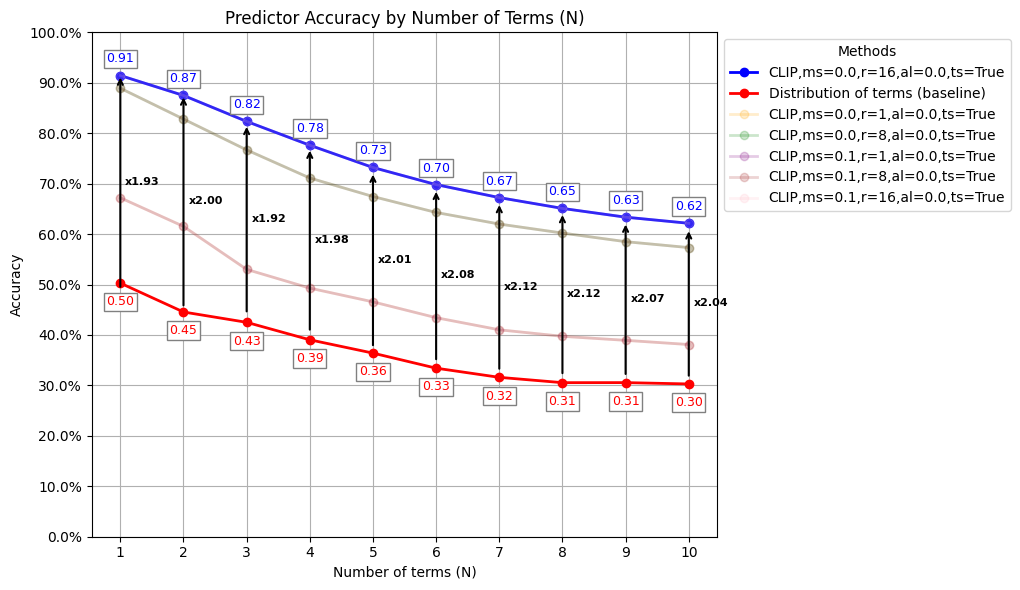

In [68]:
def plot_metrics(metrics):
    # Boxplot of the accuracies per value of N
    methods_colors = [
        "blue", "red", "orange", "green", "purple", "brown", "pink", "gray", "olive", "cyan",
        "magenta", "yellow", "teal", "navy", "maroon", "lime", "coral", "gold", "indigo", "violet",
        "darkorange", "darkgreen", "darkred", "darkblue", "darkpurple", "darkbrown", "darkpink", "darkgray"
    ]
    Ns = sorted(metrics["N"].unique())
    methods = list(metrics["method"].unique())

    # Get the method with "CLIP" in its name that has the highest mean accuracy
    best_method = metrics[metrics["method"].str.contains("CLIP")].groupby("method")["accuracy"].mean().idxmax()

    best_method_minus_baseline = []
    for N in Ns:
        baseline_accuracy = metrics[(metrics["method"] == "Distribution of terms (baseline)") & (metrics["N"] == N)]["accuracy"].values[0]
        clip_accuracy = metrics[(metrics["method"] == best_method) & (metrics["N"] == N)]["accuracy"].values[0]
        best_method_minus_baseline.append(clip_accuracy/baseline_accuracy)

    # Remove best_method from the list of methods to plot it first
    methods.remove(best_method)
    methods = [best_method] + methods

    fig, ax = plt.subplots(figsize=(10, 6))

    # Add an arrow from the baseline to the best method with best_method_minus_baseline text
    for N in Ns:
        baseline_accuracy = metrics[(metrics["method"] == "Distribution of terms (baseline)") & (metrics["N"] == N)]["accuracy"].values[0]
        best_accuracy = metrics[(metrics["method"] == best_method) & (metrics["N"] == N)]["accuracy"].values[0]
        ax.annotate(
            f"",
            xy=(N, best_accuracy - 0.01),
            xytext=(N, baseline_accuracy + 0.01),
            arrowprops=dict(arrowstyle="->", color='black', lw=1.5),
            fontsize=9,
            color='black',
            alpha=0.7
        )

    for i, method in enumerate(methods):
        method_metrics = metrics[metrics["method"] == method]
        method_color = methods_colors[i]

        accuracies = []
        for N in Ns:
            N_metrics = method_metrics[method_metrics["N"] == N]
            accuracies.append(np.mean(N_metrics["accuracy"].values))

        alpha = 0.2
        if method == best_method or "baseline" in method:
            alpha = 1.0

        if method == best_method or "baseline" in method:
            # Add the values over the points for the best method
            dy = 0.02 if method == best_method else -0.05
            for j, accuracy in enumerate(accuracies):
                ax.text(Ns[j], accuracy + dy, f"{accuracy:.2f}", 
                    ha='center', va='bottom', fontsize=9, color=method_color, bbox=dict(facecolor='white', alpha=1.0, edgecolor='grey', pad=2))

        ax.plot(Ns, accuracies, marker='o', label=method, color=method_color, alpha=alpha, linewidth=2)

    # Add a text in the middle of the arrow with the best_method_minus_baseline
    for j, N in enumerate(Ns):
        baseline_accuracy = metrics[(metrics["method"] == "Distribution of terms (baseline)") & (metrics["N"] == N)]["accuracy"].values[0]
        clip_accuracy = metrics[(metrics["method"] == best_method) & (metrics["N"] == N)]["accuracy"].values[0]
        py = baseline_accuracy + (clip_accuracy - baseline_accuracy) / 2
        ax.text(N + 0.35, py, f"x{best_method_minus_baseline[j]:.2f}", 
            ha='center', va='center', fontsize=8, color='black', fontweight='bold')

    ax.set_xticks(Ns)
    ax.set_xticklabels(Ns)
    ax.set_xlabel("Number of terms (N)")
    ax.set_ylabel("Accuracy")

    plt.title("Predictor Accuracy by Number of Terms (N)")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Methods")
    plt.tight_layout()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.yticks(np.arange(0, 1.1, 0.1), fontsize=10, labels=[f"{i*100:.1f}%" for i in np.arange(0, 1.1, 0.1)])
    plt.savefig(FOLDER_FIGURES + "predictor_accuracy_by_N.pdf", dpi=300, bbox_inches='tight')
    print("Plot saved to:", FOLDER_FIGURES + "predictor_accuracy_by_N.pdf")
    plt.show()

plot_metrics(all_metrics)

In [69]:
predictions_folder = "../../private_data/predictions"
if not os.path.exists(predictions_folder):
    os.makedirs(predictions_folder)

In [86]:
GT_TRAIN_RAW_path = predictions_folder + "/GT_TRAIN_RAW.json"

if os.path.exists(GT_TRAIN_RAW_path):
    print(f"File {GT_TRAIN_RAW_path} already exists. Loading it.")
    with open(GT_TRAIN_RAW_path, "r") as f:
        predictions_per_recordID = json.load(f)

    # Cast keys to int
    predictions_per_recordID = {int(k): v for k, v in predictions_per_recordID.items()}
else:

    predictor = predict_with_CLIP_neighbours(
        wterms_recordIDs, 
        E, 
        T
    )
    # Generate predictions for ALL recordIDs then train a new predictor
    predictions_per_recordID = {}
    for a_i in tqdm(all_recordIDs, desc="Generating predictions for all recordIDs"):
        index = recordID_to_index[a_i]
        e_i = Embeddings[index]
        predicted_terms, scores = predictor(
            a_i,
            e_i,
            terms_per_identifier=terms_per_recordID,
            known=[], 
            banned=[], 
            min_sim=0.0, 
            epsilon=1e-10, 
            regionality=16.0, 
            alpha=0.0, 
            useTermsSimilarity=True, 
            N=0.5
        )
        predictions_per_recordID[int(a_i)] = predicted_terms

    # Save the predictions to a JSON file
    with open(GT_TRAIN_RAW_path, "w") as f:
        json.dump(predictions_per_recordID, f, indent=4)

File ../../private_data/predictions/GT_TRAIN_RAW.json already exists. Loading it.


In [71]:
lengths_per_recordID = {recordID: len(terms) for recordID, terms in predictions_per_recordID.items()}
print(f"Mean number of predicted terms per recordID: {np.mean(list(lengths_per_recordID.values())):.2f}")
print(f"Median number of predicted terms per recordID: {np.median(list(lengths_per_recordID.values())):.2f}")
print(f"Max number of predicted terms per recordID: {np.max(list(lengths_per_recordID.values())):.2f}")
print(f"Min number of predicted terms per recordID: {np.min(list(lengths_per_recordID.values())):.2f}")

Mean number of predicted terms per recordID: 4.47
Median number of predicted terms per recordID: 4.00
Max number of predicted terms per recordID: 30.00
Min number of predicted terms per recordID: 1.00


Metrics for ground truth:
    correct_prc: 0.8066 (std: 0.2278)
    incorrect_prc: 0.1934 (std: 0.2278)
    missing_prc: 0.5852 (std: 0.2312)
    nb_predictions: 4.5260 (std: 2.5801)
    accuracy@1: 0.9135 (std: 0.2811)
    accuracy@MAX3: 0.8537 (std: 0.2300)
Most missing terms: [('animal', 342), ('femme', 325), ('scène', 321), ('vêtement', 312), ('assis', 292), ('chapeau', 275), ('couvre-chef', 266), ('groupe de figures', 259), ('arbre', 233), ('enfant', 218)]
Most overflowing terms: [('groupe de figures', 236), ('homme', 221), ('paysage', 215), ('figure', 212), ('femme', 155), ('scène', 154), ('portrait', 128), ('nu', 99), ('arbre', 99), ('vêtement', 83)]


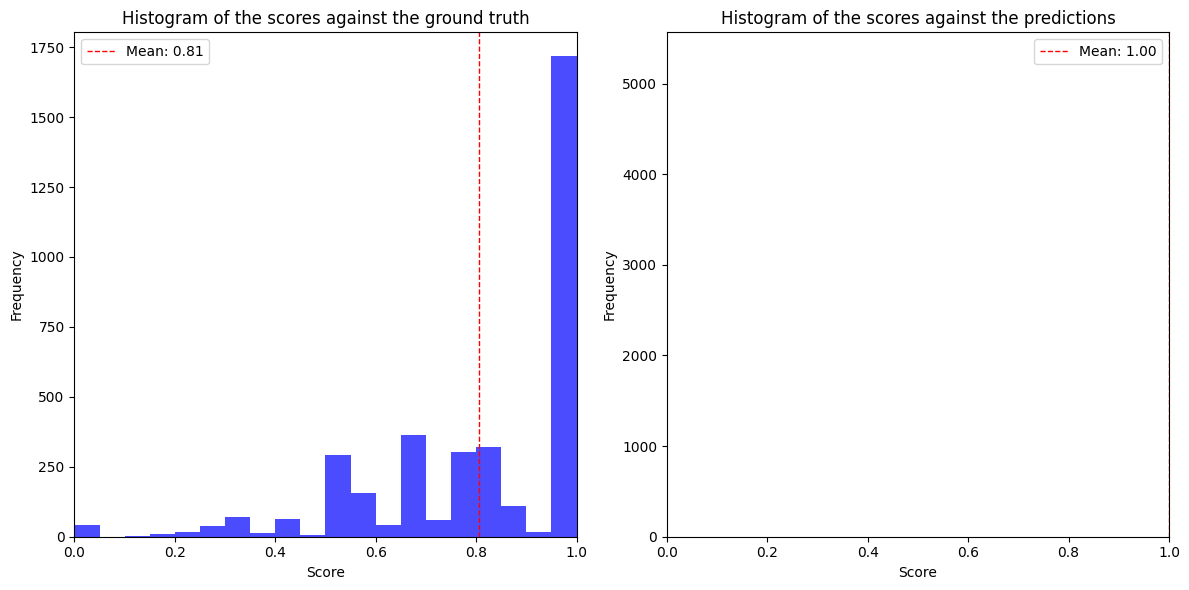

1

In [72]:
def compare_sets(predictions, plot=True):
    scores_per_comp = {}
    
    metrics_to_gt = {
        "correct_prc": [], # % of predicted terms that are correct
        "incorrect_prc": [], # % of predicted terms that are incorrect
        "missing_prc": [], # % of terms that are not in the predictions but in the ground truth
        "terms_missing": [], # Number of terms missing in the predictions
        "terms_overflow": [], # Number of terms in the predictions that are not in the ground truth
        "nb_predictions": [], # Number of predictions made
        "accuracy@1": [], # Accuracy at 1
        "accuracy@MAX3": [], # Accuracy at MAX3 3
    }
    

    for comp in ["ground_truth", "predictions"]:
        scores = []
        for recordID, predicted_terms in predictions.items():
            if comp=="ground_truth":
                true_terms_holder = terms_per_recordID
                doWeKnowTruth = recordID in wterms_recordIDs
            else:
                true_terms_holder = predictions_per_recordID
                doWeKnowTruth = True

            if doWeKnowTruth:
                true_terms = true_terms_holder[recordID]
                intersection = set(predicted_terms).intersection(set(true_terms))
                if len(predicted_terms) == 0:
                    score = 0.0
                else:
                    score = len(intersection) / len(predicted_terms) # Measure if the predicted terms are relevant
                scores.append(score)

                if comp == "ground_truth":
                    # Calculate metrics for ground truth
                    if len(predicted_terms) > 0:
                        metrics_to_gt["correct_prc"].append(len(intersection) / len(predicted_terms))
                        metrics_to_gt["incorrect_prc"].append(len(set(predicted_terms).difference(set(true_terms))) / len(predicted_terms))
                    else:
                        metrics_to_gt["correct_prc"].append(0.0)
                        metrics_to_gt["incorrect_prc"].append(0.0)

                    metrics_to_gt["missing_prc"].append(len(set(true_terms).difference(set(predicted_terms))) / len(true_terms))
                    metrics_to_gt["terms_missing"].append(set(true_terms).difference(set(predicted_terms)))
                    metrics_to_gt["terms_overflow"].append(set(predicted_terms).difference(set(true_terms)))

                    metrics_to_gt["nb_predictions"].append(len(predicted_terms))

                    if len(predicted_terms) == 0:
                        metrics_to_gt["accuracy@1"].append(0.0)
                        metrics_to_gt["accuracy@MAX3"].append(0.0)
                    else:
                        metrics_to_gt["accuracy@1"].append(1.0 if predicted_terms[0] in true_terms else 0.0)
                        correct = 0
                        total = 0
                        for i in range(3):
                            if i < len(predicted_terms):
                                term = predicted_terms[i]
                                if term in true_terms:
                                    correct += 1
                                total += 1
                        metrics_to_gt["accuracy@MAX3"].append(correct / total)

        scores_per_comp[comp] = scores

    # Print the metrics
    print(f"Metrics for ground truth:")
    for metricName in ["correct_prc", "incorrect_prc", "missing_prc", "nb_predictions", "accuracy@1", "accuracy@MAX3"]:
        values = metrics_to_gt[metricName]
        print(f"    {metricName}: {np.mean(values):.4f} (std: {np.std(values):.4f})")

    # Get the terms that are most missing or overflowing
    def get_most_frequent(terms, n=10):
        term_counts = {}
        for entries in terms:
            for term in entries:
                if term in term_counts:
                    term_counts[term] += 1
                else:
                    term_counts[term] = 1
 
        sorted_terms = sorted(term_counts.items(), key=lambda x: x[1], reverse=True)
        return sorted_terms[:n]

    most_missing_terms = get_most_frequent(metrics_to_gt["terms_missing"], n=10)
    most_overflow_terms = get_most_frequent(metrics_to_gt["terms_overflow"], n=10)
    print(f"Most missing terms: {most_missing_terms}")
    print(f"Most overflowing terms: {most_overflow_terms}")

    if plot:
        # Plot two histograms side by sideistograms side by side
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        axs[0].hist(scores_per_comp["ground_truth"], bins=20, color='blue', alpha=0.7)
        axs[0].set_title('Histogram of the scores against the ground truth')
        axs[0].set_xlabel('Score')
        axs[0].set_ylabel('Frequency')
        axs[0].set_xlim(0, 1)
        # Add vertical line at the mean
        axs[0].axvline(np.mean(scores_per_comp["ground_truth"]), color='red', linestyle='dashed', linewidth=1, label=f"Mean: {np.mean(scores_per_comp['ground_truth']):.2f}")
        axs[0].legend()

        axs[1].hist(scores_per_comp["predictions"], bins=20, color='orange', alpha=0.7)
        axs[1].set_title('Histogram of the scores against the predictions')
        axs[1].set_xlabel('Score')
        axs[1].set_ylabel('Frequency')
        axs[1].set_xlim(0, 1)
        # Add vertical line at the mean
        axs[1].axvline(np.mean(scores_per_comp["predictions"]), color='red', linestyle='dashed', linewidth=1, label=f"Mean: {np.mean(scores_per_comp['predictions']):.2f}")
        axs[1].legend()

        

        plt.tight_layout()
        plt.show()
        
    return metrics_to_gt

compare_sets(predictions_per_recordID)
1

In [81]:
# Test it
all_recordIDs_as_list = list(all_recordIDs)


File ../../private_data/predictions/GT_TRAIN_PADDED.json already exists. Loading it.
Predicted terms for recordID 10361 (embedding index 4416):
    > paysage : 1.0000
    > arbre : 0.7610


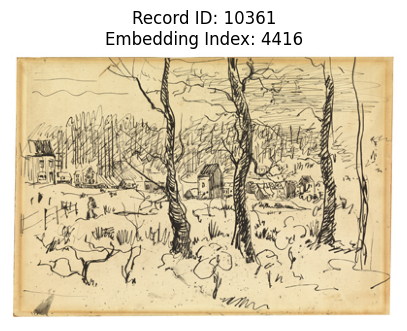

In [87]:
# Combine the ground truth and the predictions into a single predictor
GT_TRAIN_PADDED_path = predictions_folder + "/GT_TRAIN_PADDED.json"
if os.path.exists(GT_TRAIN_PADDED_path):
    print(f"File {GT_TRAIN_PADDED_path} already exists. Loading it.")
    with open(GT_TRAIN_PADDED_path, "r") as f:
        padded_predictions = json.load(f)

    # Cast keys to int
    padded_predictions = {int(k): v for k, v in padded_predictions.items()}
else:
    print(f"File {GT_TRAIN_PADDED_path} does not exist. Padding the predictions.")
    padded_predictions = terms_per_recordID.copy()
    average_length_before = np.mean([len(terms) for terms in padded_predictions.values()])
    for recordID, terms in padded_predictions.items():
        if len(terms) == 0:
            padded_predictions[recordID] = predictions_per_recordID[recordID]
        else:
            padded_predictions[recordID] = list(padded_predictions[recordID])
    average_length_after = np.mean([len(terms) for terms in padded_predictions.values()])
    print(f"Average number of terms per recordID before padding: {average_length_before:.2f}")
    print(f"Average number of terms per recordID after padding: {average_length_after:.2f}")

    # Cast keys to int
    padded_predictions = {int(k): v for k, v in padded_predictions.items()}

    # Save the padded predictions to a JSON file
    with open(GT_TRAIN_PADDED_path, "w") as f:
        json.dump(padded_predictions, f, indent=4)


# Compute E_all
E_all = []
for recordID in all_recordIDs_as_list:
    index = recordID_to_index[recordID]
    embedding = Embeddings[index]
    E_all.append(embedding)
E_all = np.array(E_all)

# provided_terms_per_recordID=padded_predictions
predictor_from_predictions = predict_with_CLIP_neighbours(
    all_recordIDs_as_list,
    E_all,
    T
)

a_i = random.choice(all_recordIDs_as_list)
index = recordID_to_index[a_i]
e_i = Embeddings[index]
known = []
banned = []

visualize(
    predictor_from_predictions,
    e_i,
    a_i,
    index,
    padded_predictions,
    known=known,
    banned=banned,
    min_sim=0.0, 
    epsilon=1e-10, 
    regionality=16.0, 
    alpha=0.0, 
    useTermsSimilarity=True, 
    N=0.5
)

In [56]:
predictor_from_predictions(
    a_i,
    e_i,
    padded_predictions,
    known=known,
    banned=banned,
    min_sim=0.0, 
    epsilon=1e-10, 
    regionality=16.0, 
    alpha=0.0, 
    useTermsSimilarity=True, 
    N=0.5
)

(['homme', 'nu'], array([1.        , 0.61807057]))

In [77]:
predictions_per_recordID_from_padded_per_N = {}
for N in np.arange(5, 100, 2.5) / 100.0:

    predictions_per_recordID_from_padded_N_path = predictions_folder + f"/predictions_per_recordID_from_padded_N={N:.2f}.json"
    if os.path.exists(predictions_per_recordID_from_padded_N_path):
        print(f"File {predictions_per_recordID_from_padded_N_path} already exists. Loading it.")
        with open(predictions_per_recordID_from_padded_N_path, "r") as f:
            predictions_per_recordID_from_padded = json.load(f)
        predictions_per_recordID_from_padded_per_N[N] = predictions_per_recordID_from_padded

        # Cast keys to int
        predictions_per_recordID_from_padded_per_N[N] = {int(k): v for k, v in predictions_per_recordID_from_padded.items()}
    else:
        print(f"File {predictions_per_recordID_from_padded_N_path} does not exist. Generating predictions for N={N:.2f}.")
        # Generate predictions for all recordIDs with the new predictor
        predictions_per_recordID_from_padded = {}
        for a_i in tqdm(all_recordIDs_as_list, desc=f"Generating predictions for all recordIDs with new predictor (N={N})"):

            index = recordID_to_index[a_i]
            e_i = Embeddings[index]
            
            predicted_terms, scores = predictor_from_predictions(
                a_i,
                e_i,
                padded_predictions,
                known=[], 
                banned=[], 
                min_sim=0.0, 
                epsilon=1e-10, 
                regionality=16.0, 
                alpha=0.0, 
                useTermsSimilarity=True, 
                N=N   
            )
            predictions_per_recordID_from_padded[a_i] = predicted_terms
        predictions_per_recordID_from_padded_per_N[N] = predictions_per_recordID_from_padded

        # Cast keys to int
        predictions_per_recordID_from_padded = {int(k): v for k, v in predictions_per_recordID_from_padded.items()}

        # Save the predictions to a JSON file
        with open(predictions_per_recordID_from_padded_N_path, "w") as f:
            json.dump(predictions_per_recordID_from_padded, f, indent=4)

File ../../private_data/predictions/predictions_per_recordID_from_padded_N=0.05.json already exists. Loading it.
File ../../private_data/predictions/predictions_per_recordID_from_padded_N=0.07.json already exists. Loading it.
File ../../private_data/predictions/predictions_per_recordID_from_padded_N=0.10.json already exists. Loading it.
File ../../private_data/predictions/predictions_per_recordID_from_padded_N=0.12.json already exists. Loading it.
File ../../private_data/predictions/predictions_per_recordID_from_padded_N=0.15.json already exists. Loading it.
File ../../private_data/predictions/predictions_per_recordID_from_padded_N=0.17.json already exists. Loading it.
File ../../private_data/predictions/predictions_per_recordID_from_padded_N=0.20.json already exists. Loading it.
File ../../private_data/predictions/predictions_per_recordID_from_padded_N=0.23.json already exists. Loading it.
File ../../private_data/predictions/predictions_per_recordID_from_padded_N=0.25.json already exi

In [78]:
correct_prcs = []
incorrect_prcs = []
missing_prcs = []
nb_predictions = []
accuracy_at_1 = []
accuracy_at_3 = []

for N, predictions_per_recordID_from_padded in predictions_per_recordID_from_padded_per_N.items():
    print(f"Evaluating predictions for N={N}...")
    metrics = compare_sets(predictions_per_recordID_from_padded, plot=False)
    correct_prcs.append(metrics["correct_prc"])
    incorrect_prcs.append(metrics["incorrect_prc"])
    missing_prcs.append(metrics["missing_prc"])
    nb_predictions.append(metrics["nb_predictions"])
    accuracy_at_1.append(metrics["accuracy@1"])
    accuracy_at_3.append(metrics["accuracy@MAX3"])

Evaluating predictions for N=0.05...
Metrics for ground truth:
    correct_prc: 0.2751 (std: 0.1408)
    incorrect_prc: 0.7249 (std: 0.1408)
    missing_prc: 0.2103 (std: 0.1848)
    nb_predictions: 31.4298 (std: 18.2962)
    accuracy@1: 0.9014 (std: 0.2981)
    accuracy@MAX3: 0.8153 (std: 0.2358)
Most missing terms: [('oiseau', 57), ('couvre-chef', 55), ('panier', 48), ('de profil', 43), ('bâtiment', 42), ('chaussure', 42), ('coiffure', 40), ('manteau', 40), ('jeune homme', 39), ('ciel', 39)]
Most overflowing terms: [('homme', 1362), ('scène', 1336), ('figure', 1323), ('animal', 1307), ('assis', 1267), ('femme', 1265), ('vêtement', 1191), ('groupe de figures', 1179), ('enfant', 1112), ('en pied', 1098)]
Evaluating predictions for N=0.075...
Metrics for ground truth:
    correct_prc: 0.3500 (std: 0.1654)
    incorrect_prc: 0.6500 (std: 0.1654)
    missing_prc: 0.2566 (std: 0.1995)
    nb_predictions: 22.6858 (std: 13.2015)
    accuracy@1: 0.9014 (std: 0.2981)
    accuracy@MAX3: 0.8154 

Plot saved to: ./../.././public/figures/metrics_per_N_pred.pdf


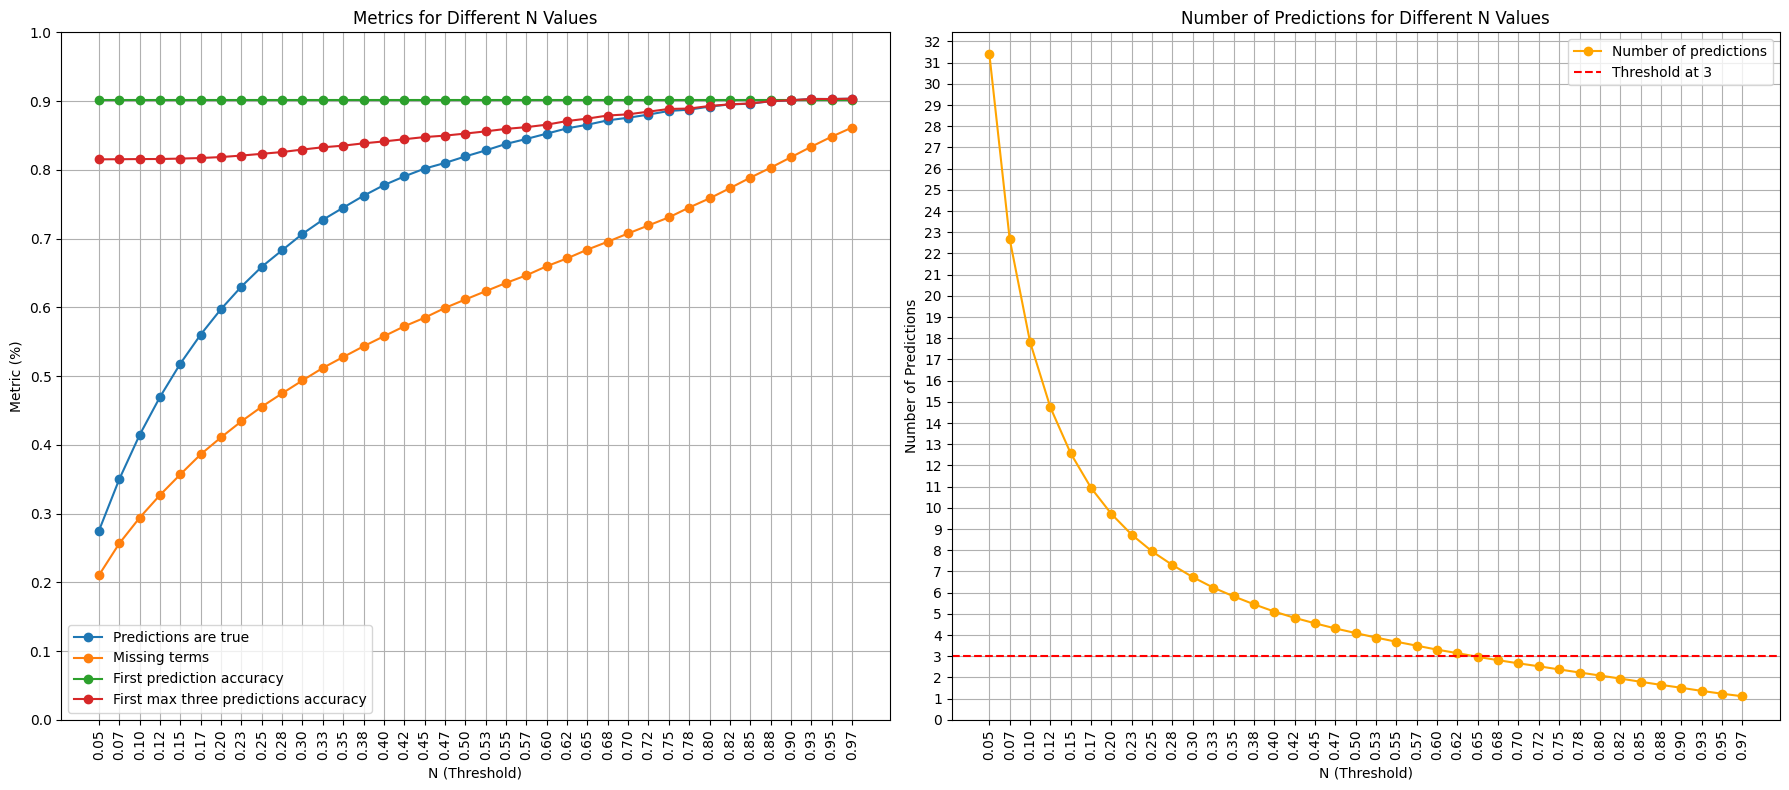

In [ ]:
# Plot the metrics for each N
X = list(predictions_per_recordID_from_padded_per_N.keys())
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

correct_prcs_np = np.array([np.mean(prc) for prc in correct_prcs])
missing_prcs_np = np.array([np.mean(prc) for prc in missing_prcs])
nb_predictions_np = np.array([np.mean(prc) for prc in nb_predictions])
accuracy_at_1_np = np.array([np.mean(prc) for prc in accuracy_at_1])
accuracy_at_MAX3_np = np.array([np.mean(prc) for prc in accuracy_at_3])

axs[0].plot(X, correct_prcs_np, label='Predictions are true', marker='o')
axs[0].plot(X, missing_prcs_np, label='Missing terms', marker='o')
axs[0].plot(X, accuracy_at_1_np, label='First prediction accuracy', marker='o')
axs[0].plot(X, accuracy_at_MAX3_np, label='First max three predictions accuracy', marker='o')
axs[0].set_xlabel('N (Threshold)')
axs[0].set_ylabel('Metric (%)')
axs[0].set_title('Metrics for Different N Values')
axs[0].set_ylim([0, 1])
axs[0].set_yticks(np.arange(0, 1.1, 0.1))
axs[0].set_xticks(X, labels=[f"{x:.2f}" for x in X], rotation=90)
axs[0].legend()
axs[0].grid()

axs[1].plot(X, nb_predictions_np, label='Number of predictions', marker='o', color='orange')
axs[1].set_xlabel('N (Threshold)')
axs[1].set_ylabel('Number of Predictions')
axs[1].set_title('Number of Predictions for Different N Values')
axs[1].set_ylim([0, max(nb_predictions_np) + 1])
axs[1].set_yticks(np.arange(0, max(nb_predictions_np) + 1, 1))
axs[1].set_xticks(X, labels=[f"{x:.2f}" for x in X], rotation=90)
# Add a horizontal line at y=3
axs[1].axhline(y=3, color='red', linestyle='--', label='Threshold at 3')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.savefig(FOLDER_FIGURES + "metrics_per_N_pred.pdf", dpi=300, bbox_inches='tight')
print("Plot saved to:", FOLDER_FIGURES + "metrics_per_N_pred.pdf")
plt.show()

Using predictions from padded terms with N=0.50
Metrics for ground truth:
    correct_prc: 0.8195 (std: 0.2326)
    incorrect_prc: 0.1805 (std: 0.2326)
    missing_prc: 0.6114 (std: 0.2309)
    nb_predictions: 4.0939 (std: 2.3071)
    accuracy@1: 0.9014 (std: 0.2981)
    accuracy@MAX3: 0.8527 (std: 0.2340)
Most missing terms: [('animal', 398), ('femme', 388), ('scène', 333), ('assis', 325), ('vêtement', 324), ('chapeau', 307), ('couvre-chef', 274), ('groupe de figures', 255), ('arbre', 248), ('enfant', 247)]
Most overflowing terms: [('figure', 248), ('paysage', 243), ('groupe de figures', 235), ('homme', 233), ('scène', 139), ('femme', 133), ('portrait', 126), ('nu', 98), ('arbre', 76), ('eau', 68)]


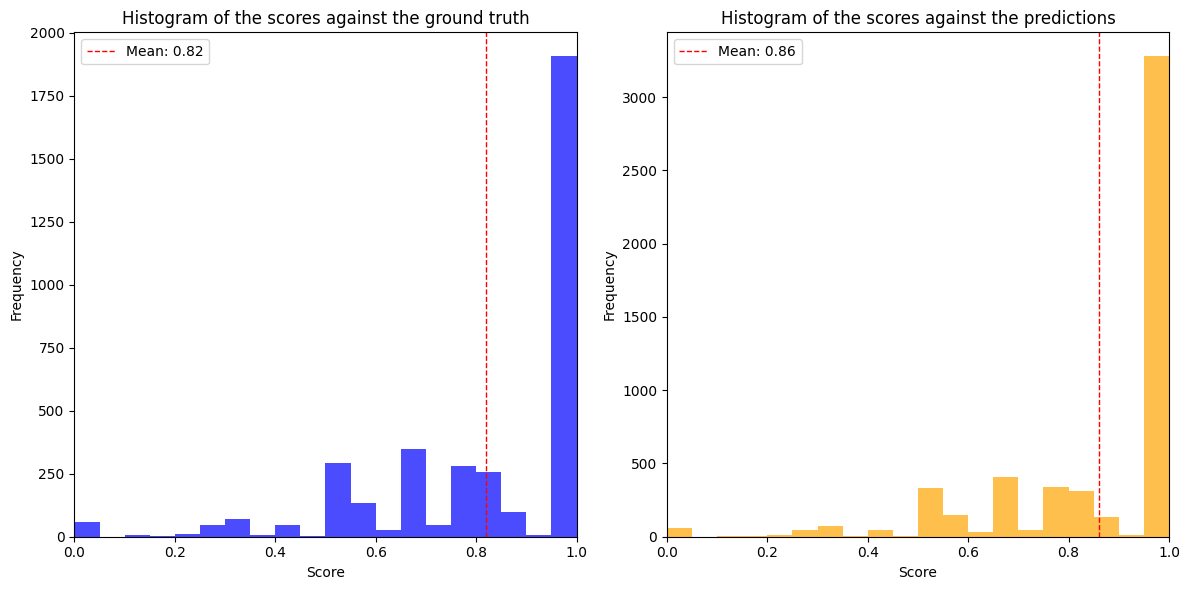

1

In [80]:
selected_N = 0.5
print(f"Using predictions from padded terms with N={selected_N:.2f}")
compare_sets(predictions_per_recordID_from_padded_per_N[selected_N])
1

Using predictions from padded terms with N=0.50
File ../../private_data/predictions/predictions_per_recordID_without_modifying_GT_N=0.50.json does not exist. Generating predictions without modifying the ground truth.
Metrics for ground truth:
    correct_prc: 1.0000 (std: 0.0000)
    incorrect_prc: 0.0000 (std: 0.0000)
    missing_prc: 0.0000 (std: 0.0000)
    nb_predictions: 10.1700 (std: 6.6939)
    accuracy@1: 1.0000 (std: 0.0000)
    accuracy@MAX3: 1.0000 (std: 0.0000)
Most missing terms: []
Most overflowing terms: []


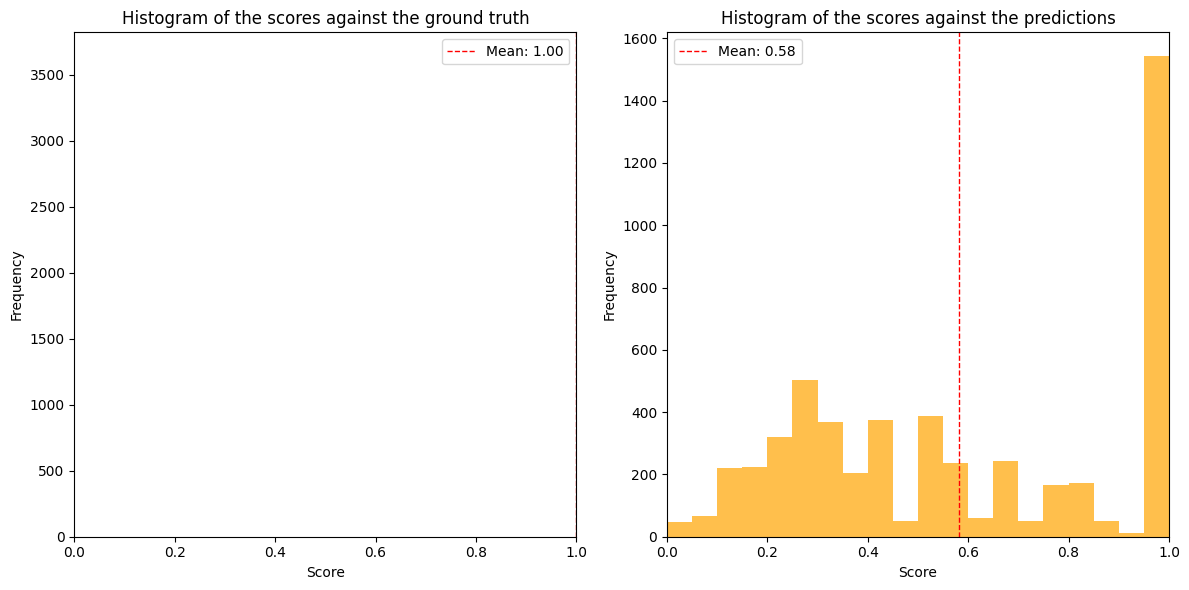

1

In [82]:
selected_N = 0.5
print(f"Using predictions from padded terms with N={selected_N:.2f}")

predictions_per_recordID_without_modifying_GT_path = predictions_folder + f"/predictions_per_recordID_without_modifying_GT_N={selected_N:.2f}.json"
if os.path.exists(predictions_per_recordID_without_modifying_GT_path):
    print(f"File {predictions_per_recordID_without_modifying_GT_path} already exists. Loading it.")
    with open(predictions_per_recordID_without_modifying_GT_path, "r") as f:
        predictions_per_recordID_without_modifying_GT = json.load(f)

    # Cast keys to int
    predictions_per_recordID_without_modifying_GT = {int(k): v for k, v in predictions_per_recordID_without_modifying_GT.items()}
else:
    print(f"File {predictions_per_recordID_without_modifying_GT_path} does not exist. Generating predictions without modifying the ground truth.")
    predictions_per_recordID_without_modifying_GT = {}
    predictions_per_recordID_from_padded = predictions_per_recordID_from_padded_per_N[selected_N]

    for recordID in all_recordIDs_as_list:
        if recordID in wterms_recordIDs:
            # If the recordID is in the ground truth, we keep the original terms
            predictions_per_recordID_without_modifying_GT[recordID] = list(terms_per_recordID[recordID])
        else:
            # If the recordID is not in the ground truth, we use the predictions from the padded terms
            predictions_per_recordID_without_modifying_GT[recordID] = predictions_per_recordID_from_padded[recordID]

    # Cast keys to int
    predictions_per_recordID_without_modifying_GT = {int(k): v for k, v in predictions_per_recordID_without_modifying_GT.items()}

    # Save the predictions to a JSON file
    with open(predictions_per_recordID_without_modifying_GT_path, "w") as f:
        json.dump(predictions_per_recordID_without_modifying_GT, f, indent=4)

# Compare the sets again
compare_sets(predictions_per_recordID_without_modifying_GT)
1

In [83]:
def compute_image_embedding(image_path, model, device):
    image = Image.open(image_path)
    images = [image]
    sample = processor(text=[""] * len(images), images=images, return_tensors="pt", padding=True, truncation=True)

    input_ids = sample['input_ids'].to(device)
    attention_mask = sample['attention_mask'].to(device)
    pixel_values = sample['pixel_values'].to(device)

    # Compute image embeddings
    image_features = model.get_image_features(pixel_values=pixel_values)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    image_features = image_features.flatten(1)

    image_features = image_features.cpu().detach().numpy()
    return image_features[0]

# Test it 
recordID = random.choice(wterms_recordIDs)
image_path = recordID_to_imageLowResFilename[recordID]
image_embedding = compute_image_embedding(image_path, model, device)
print(image_embedding.shape)

(768,)


In [89]:
# Host a simple web service to serve the predictions
from flask import Flask, jsonify, request
from flask_cors import CORS
from flask import send_file

app = Flask(__name__)
CORS(app)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    a_i = data.get('recordID', None)
    alpha = data.get('alpha', 0.2)
    N = data.get('N', 0.5)

    if a_i is None:
        return jsonify({"error": "a_i is required"}), 400
    
    try:
        a_i = int(a_i)
    except ValueError:
        return jsonify({"error": "a_i must be an integer"}), 400
    
    try:
        N = float(N)
        if N <= 0:
            return jsonify({"error": "N must be a positive number"}), 400
        if N > 1:
            return jsonify({"error": "N must be less than or equal to 1"}), 400
    except ValueError:
        return jsonify({"error": "N must be a float"}), 400

    if recordID not in all_recordIDs and recordID not in uploaded_recordIDs:
        return jsonify({"error": "a_i not found"}), 404

    if a_i in uploaded_recordIDs:
        index = None
        e_i = uploaded_recordID_to_embedding[a_i]
    else:
        index = recordID_to_index[a_i]
        e_i = Embeddings[index] 

    known = data.get('known', [])
    banned = data.get('banned', [])

    predicted_terms, scores = predictor_from_predictions(
        a_i,
        e_i,
        padded_predictions,
        known=known,
        banned=banned,
        min_sim=0.0, 
        epsilon=1e-10, 
        regionality=16.0, 
        alpha=alpha, 
        useTermsSimilarity=True, 
        N=N
    )
        
    return jsonify({
        "recordID": a_i,
        "predicted_terms": list(predicted_terms),
        "scores": list([float(score) for score in scores])
    })

@app.route('/image/<int:recordID>', methods=['GET'])
def get_image(recordID):
    if recordID not in all_recordIDs and recordID not in uploaded_recordIDs:
        return jsonify({"error": "RecordID not found"}), 404
    
    if recordID in uploaded_recordIDs:
        image_path = uploaded_recordID_to_imageLowResFilename[recordID]
    else:
        image_path = recordID_to_imageLowResFilename[recordID]
    
    if not os.path.exists(image_path):
        return jsonify({"error": "Image not found"}), 404
    
    return send_file(image_path, mimetype='image/jpeg')

LOCAL_UPLOAD_FOLDER = "./uploads"
uploaded_recordIDs = set()
os.makedirs(LOCAL_UPLOAD_FOLDER, exist_ok=True)

uploaded_recordID_to_imageLowResFilename = {}
uploaded_recordID_to_embedding = {}

@app.route('/upload', methods=['POST'])
def upload():

    record_id = request.form.get("recordID")
    file = request.files.get("image")

    if not record_id or not file:
        return jsonify({"error": "Missing recordID or image"}), 400
    
    try:
        record_id = int(record_id)
    except ValueError:
        return jsonify({"error": "RecordID must be an integer"}), 400

    if record_id in recordID_to_imageLowResFilename or record_id in uploaded_recordIDs:
        return jsonify({"error": "RecordID already exists"}), 400

    file_extension = file.filename.split('.')[-1].lower()

    try:
        record_id = int(record_id)
        filename = f"{record_id}.{file_extension}"
        filepath = os.path.join(LOCAL_UPLOAD_FOLDER, filename)
        file.save(filepath)
        # Update the uploaded_recordID_to_imageLowResFilename mapping
        uploaded_recordID_to_imageLowResFilename[record_id] = filepath
        # Add the new recordID to uploaded_recordIDs
        uploaded_recordIDs.add(record_id)
        # Compute the embedding for the new image
        image_embedding = compute_image_embedding(filepath, model, device)
        uploaded_recordID_to_embedding[record_id] = image_embedding

        return jsonify({"success": True})
    except Exception as e:
        return jsonify({"error": str(e)}), 500

@app.route('/random_record', methods=['GET'])
def random_record():
    return jsonify({"recordID": int(random.sample(woterms_recordIDs, 1)[0])})

# Launch the Flask app
app.run(host='0.0.0.0', port=5000)
# Tell the user how to access the app
html_file_path = os.path.join("./infer_ico_html.html")
print(f"HTML file to access the app: {html_file_path}")

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.0.17:5000
Press CTRL+C to quit
127.0.0.1 - - [01/Jun/2025 04:23:39] "GET /random_record HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2025 04:23:40] "HEAD /image/5757 HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2025 04:23:40] "OPTIONS /predict HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2025 04:23:40] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2025 04:23:40] "GET /image/5757 HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2025 04:23:41] "GET /random_record HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2025 04:23:42] "HEAD /image/883 HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2025 04:23:42] "GET /image/883 HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2025 04:23:42] "OPTIONS /predict HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2025 04:23:42] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2025 04:25:58] "OPTIONS /predict HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2025 04:25:59] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2

HTML file to access the app: ./infer_ico_html.html


In [ ]:
# Export the list of predictions
predictions_per_recordID_without_modifying_GT_formatted = {}
for recordID in predictions_per_recordID_without_modifying_GT:
    recordID = int(recordID)  # Convert recordID to int
    terms = list(predictions_per_recordID_without_modifying_GT[recordID])  # Convert terms to list
    isGroundTruth = recordID in wterms_recordIDs
    predictions_per_recordID_without_modifying_GT_formatted[recordID] = {
        "isGroundTruth": isGroundTruth,
        "terms": terms
    }

path = "../../private_data/predictions_per_recordID.json"
with open(path, "w", encoding="utf-8") as f:
    json.dump(predictions_per_recordID_without_modifying_GT_formatted, f, ensure_ascii=False, indent=4)

print(f"Predictions saved to {path}")

Predictions saved to ../../private_data/predictions_per_recordID.json
